In [ ]:
import numpy as np
from sklearn import preprocessing
from sklearn import metrics
import matplotlib
from matplotlib import pyplot as plt
import os
from keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Concatenate, Flatten, MaxPooling1D
from keras.models import Model
import pandas as pd
from itertools import islice


Set up variables for constants such as absolute datapaths and the desired valdiation fraction split.

In [11]:
datapath = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Final Data.txt"
classyfire_datapath = "G:\\Dev\\Data\\Classyfire GNPS Final Data.txt"
datapath_with_fragments = "G:\\Dev\\Data\\100000\\GNPS Python Master\\Final Data 100000 With Fragments.txt"
fingerprints_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Final Fingerprints.txt"
filtered_fingerprints_path = "G:\\Dev\\Data\\Filtered Mibig GNPS Links\\Filtered GNPS Fingerprints.tsv"
linked_fingerprints_path = "G:\\Dev\\Data\\Linked GNPS Fingerprints.tsv"
substituents_path = "G:\\Dev\\Data\\Classyfire Taxanomy\\GNPS_substituents.txt"
smiles_fingerprints_path = "G:\\Dev\\Data\\Fingerprint Bitmaps 2\\mibig_unique_smiles.txt"
npatlas_smiles_fingerprints_path = "G:\\Dev\\Data\\Fingerprint Bitmaps 2\\NPAtlas_DB_last_version_filtered.txt"
npatlas_final_families_path = "G:\\Dev\\Data\\NPAtlas_Final_Families.txt"
families_path = "G:\\Dev\\Data\\Final Smiles Families.txt"
fingerprints_names_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Fingerprint Legend.txt"
families_names_path = "G:\\Dev\\Data\\Family Legend.txt"
num_samples = 5770
num_smiles_families_samples = 1368
numSubstituents = 1413
num_val_samples = 1000
numFeatures = 2995
val_fraction = 0.1
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.1

The below are methods used to load in fragment spectra and fingerprint data from files stored in the absolute paths specified above.

In [12]:
# Loads a master file containing peak intensities for all molecules.
# Each molecule's spectrum is added as a 1000 element row to a Pandas dataframe
# The dataframe is then converted into a numpy array for use as Keras Input.
# Include the option of adding additonal features to each molecule (mass_shifts variable)
def load_master_file(path, mass_shifts = 0, number_of_bins = 1000):
    MAX_MASS = 1000
    BIN_SIZE = 1
    NUM_FEATURES = mass_shifts
    mol_all = np.loadtxt(path, dtype="U25") # Get master file in as numpy array
    
    mol_ids = np.unique(mol_all[:, 0])  # Trim duplicate filename rows, store unique filenames
    # Construct empty Pandas dataframe of correct size.
    # Number of rows is equal to the number of unique molecules (found in mol_ids).
    intensities = pd.DataFrame(0.0, index = mol_ids, columns=range((number_of_bins//BIN_SIZE)+NUM_FEATURES), dtype=float)
    
    # Populate the dataframe using each molecule's filename to place data in the correct row.
    for row in mol_all:
        intensities.at[row[0], float(row[1])-1] = float(row[2])
    
    # Convert populated dataframe into a numpy array for use by neural networks.
    np_matrix = intensities.values
    return np_matrix

# Load a master file containing CDK fingerprints for all molecules.
# Each molecules CDK bit set is added as a 320 element array to a Pandas dataframe.
def load_fingerprints_master(path, number_of_rows=0):
    BITS = 320  # Total number of bits in fingerprint

    #fp_all = np.loadtxt(fingerprints_path, dtype="U25") # Get master file as numpy array of Strings
    
    # fp_all = np.loadtxt(path, dtype="U25", skiprows=1) # skip first row of headers
    
    fp_all = np.loadtxt(path, dtype="U25", skiprows=number_of_rows) # Get master file as numpy array of Strings
    fp_ids = np.unique(fp_all[:, 0]) # Trim duplicate filename rows, store unique filenames

    # Construct empty Pandas dataframe of correct size.
    # Number of rows is equal to the number of unique molecules (found in fp_ids).
    fingerprints = pd.DataFrame(0, index = fp_ids, columns=range(BITS), dtype=int)

    # Populate the dataframe using each molecule's filename to place data in the correct row.
    for row in fp_all:
        fingerprints.at[row[0], int(row[1])] = int(row[2])

    # Convert populated dataframe into a numpy array for use as output by neural networks.
    global fingerprints_index
    fingerprints_index = fingerprints.index
    np_matrix = fingerprints.values
    return np_matrix

# Load a master file containing CDK fingerprints for all molecules.
# Each molecules CDK bit set is added as a 320 element array to a Pandas dataframe.
def load_substituents_master():
    BITS = 1413  # Total number of bits in fingerprint

    fp_all = np.loadtxt(substituents_path, dtype="U25") # Get master file as numpy array of Strings
    fp_ids = np.unique(fp_all[:, 0]) # Trim duplicate filename rows, store unique filenames

    # Construct empty Pandas dataframe of correct size.
    # Number of rows is equal to the number of unique molecules (found in fp_ids).
    substituents = pd.DataFrame(0, index = fp_ids, columns=range(BITS), dtype=int)

    # Populate the dataframe using each molecule's filename to place data in the correct row.
    for row in fp_all:
        substituents.at[row[0], int(row[1])] = int(row[2])

    # Convert populated dataframe into a numpy array for use as output by neural networks.
    
    np_matrix = substituents.values
    return np_matrix

# Load a master file containing families for all molecules.
# Each families bit set is added as a 8 element array to a Pandas dataframe.
def load_families_master(path):
    BITS = 8  # Total number of bits in families

    fp_all = np.loadtxt(path, dtype="U25") # Get master file as numpy array of Strings
    fp_ids = np.unique(fp_all[:, 0]) # Trim duplicate filename rows, store unique filenames

    # Construct empty Pandas dataframe of correct size.
    # Number of rows is equal to the number of unique molecules (found in fp_ids).
    families = pd.DataFrame(0, index = fp_ids, columns=range(BITS), dtype=int)

    # Populate the dataframe using each molecule's filename to place data in the correct row.
    for row in fp_all:
        families.at[row[0], int(row[1])] = int(row[2])

    # Convert populated dataframe into a numpy array for use as output by neural networks.
    np_matrix = families.values
    return np_matrix

# Load the names of all substructures included in the CDK fingerprint in the correct order
# This is used for boxplots, when performance metrics for individual substructures are calculated.
def load_fingerprint_legend():
    fingerprint_legend = []
    # Open file containing substructure names.
    with open(fingerprints_names_path, 'r') as f:
        # Add each name to the list of substructure names.
        lines = list(islice(f, 0, None))
        for line in lines:
            fingerprint_legend.append(line)
    return fingerprint_legend

# Load the names of all families included in the correct order
def load_family_legend():
    family_legend = []
    # Open file containing substructure names.
    with open(families_names_path, 'r') as f:
        # Add each name to the list of substructure names.
        lines = list(islice(f, 0, None))
        for line in lines:
            family_legend.append(line)
    return family_legend

The below methods create and train various neural networks when provided with valid input and output data. They allow for specifying the number of epochs the network is to be trained for and, in some cases, the learning rate. Trained models are returned and can be used to predict on test data and thereby be evaluated.

In [13]:
# Import Sotchastic Gradient Descent object from Keras to allow for tweaking its learning rate.
from keras.optimizers import SGD

# A deep autoencoder which learns to reconstruct fragment spectra.
# Structure: (Input)1000-256-128-16-128-256-1000(Output)
def basic_autoencoder(x_train, epochs=100, encoded_dim=10):
    # Create input based on the provided x_train data structure.
    inputLayer = Input(shape=(x_train.shape[1],))  # fixed
    # Since an autoencoder reconstructs input, output will have the same shape as input.
    output_dims = x_train.shape[1]

    # Create the encoding layers using Keras' functional API.
    l = inputLayer
    l = Dense(256, activation='relu')(l)
    l = Dense(128, activation='relu')(l)
    l = Dense(16, activation='relu')(l)
    
    # Create reference to latent space in case we need it later for interpolation(not used in the end)
    latent_space = l

    # Create decoding layers using functional API. 
    l2 = Dense(128, activation='relu')(l)
    l2 = Dense(256, activation='relu')(l2)
    l2 = Dense(output_dims, activation='relu')(l2)

    # Store reference to final output.
    out_layer = l2

    auto_model = Model(input=inputLayer, output=out_layer)  # Create model.
    
    # Set SGD learning rate and compile model with MSE as loss function.
    sgd = SGD(lr=0.1)
    auto_model.compile(loss='mean_squared_error', optimizer=sgd)

    # Train the model for the specified number of epochs, using the specified validation fraction.
    autoencoder_train = auto_model.fit(x_train, x_train, shuffle=False, validation_split = val_fraction, epochs=epochs)
    
    # Once traning is done, plot model loss and validation loss
    # This is a visual guide for how well the model is learning (is it overfitting, underfitting?)
    plot_loss(autoencoder_train, epochs)
    
    return auto_model  # Return the model, now trained.

# An encoder which learns to turn fragment spectra into CDK fingerprints for the same molecule.
# Structure: (Input)1000-256-128-16-128-256-307(Output)
def fingerprint_autoencoder(x_train_spectra, x_train_fingerprints, epochs=100, lr=0.5):
    # Create input based on the provided x_train data structure.
    input_layer = Input(shape=(x_train_spectra.shape[1],))
    # Since output is not the same as input, we obtain its shape separately.
    output_dims = x_train_fingerprints.shape[1]
    
    # Create the encoding layers using functional API.
    l = input_layer
    l = Dense(256, activation='relu')(l)
    l = Dense(128, activation='relu')(l)
    l = Dense(16, activation='relu')(l)
    
    # Create reference to latent space
    latent_space = l
    
    # Create decoding layers using functional API.
    l2 = Dense(128, activation='relu')(l)
    # Linear activation function followed by sigmoid to get outputs between 0 and 1.
    # This is done because the output fingerprint is a set of bits (0 or 1).
    # Linear activation ensures that values can be negative (necessary for sigmoid to function)
    l2 = Dense(256, activation='linear')(l2)
    l2 = Dense(output_dims, activation='sigmoid')(l2)
    
     # Store reference to final output.
    out_layer = l2
    
    auto_model = Model(input=input_layer, output=out_layer)
    
    # Set SGD learning rate provided as parameter and compile model with MSE as loss function.
    sgd = SGD(lr=lr)
    auto_model.compile(loss='mean_squared_error', optimizer=sgd)
    
    # Train the model for the specified number of epochs, using the specified validation fraction.
    autoencoder_train = auto_model.fit(x_train_spectra, x_train_fingerprints, shuffle=False, validation_split = val_fraction, epochs=epochs)
    
    # Once traning is done, plot model loss and validation loss
    plot_loss(autoencoder_train, epochs)
    
    return auto_model # Return the model, now trained.

# A simplified spectrum-fingeprrint encoder.
# Structure: (Input)1000-500-200-307(Output)
def simplified_fingerprint_autoencoder(x_train_spectra, x_train_fingerprints, epochs=100, lr=0.5):
    # Create input based on the provided x_train data structure.
    input_layer = Input(shape=(x_train_spectra.shape[1],))
    # Since output is not the same as input, we obtain its shape separately.
    output_dims = x_train_fingerprints.shape[1]
    
    # Create the encoding layers using functional API.
    l = input_layer
    l = Dense(500, activation='relu')(l)
    
    # Linear activation ensures that values can be negative (necessary for sigmoid to function)
    l = Dense(200, activation='linear')(l)
    
    # Save reference to latent space
    latent_space = l
    
    # Sigmoid activation to get outputs between 0 and 1. This is done because the output fingerprint is a set of bits (0 or 1).
    l2 = Dense(output_dims, activation='sigmoid')(l)
    
    #Reference for output layer
    out_layer = l2

    auto_model = Model(input=input_layer, output=out_layer)
    
    # Set SGD learning rate provided as parameter and compile model with MSE as loss function.
    sgd = SGD(lr=lr)
    auto_model.compile(loss='mean_squared_error', optimizer=sgd)
    
    # Train the model for the specified number of epochs, using the specified validation fraction.
    autoencoder_train = auto_model.fit(x_train_spectra, x_train_fingerprints, shuffle=False, validation_split = 0.1, epochs=epochs)
    
    # Loss Plots
    plot_loss(autoencoder_train, epochs)
    
    return auto_model # Return model, now trained

# A simplified spectrum-fingeprrint encoder.
# Structure: (Input)1000-500-200-1413(Output)
def simplified_substituent_autoencoder(x_train_spectra, x_train_substituents, epochs=100, lr=0.5):
    # Create input based on the provided x_train data structure.
    input_layer = Input(shape=(x_train_spectra.shape[1],))
    # Since output is not the same as input, we obtain its shape separately.
    output_dims = x_train_substituents.shape[1]
    
    # Create the encoding layers using functional API.
    l = input_layer
    l = Dense(500, activation='relu')(l)
    
    # Linear activation ensures that values can be negative (necessary for sigmoid to function)
    l = Dense(200, activation='linear')(l)
    
    # Save reference to latent space
    latent_space = l
    
    # Sigmoid activation to get outputs between 0 and 1. This is done because the output fingerprint is a set of bits (0 or 1).
    l2 = Dense(output_dims, activation='sigmoid')(l)
    
    #Reference for output layer
    out_layer = l2

    auto_model = Model(input=input_layer, output=out_layer)
    
    # Set SGD learning rate provided as parameter and compile model with MSE as loss function.
    sgd = SGD(lr=lr)
    auto_model.compile(loss='mean_squared_error', optimizer=sgd)
    
    # Train the model for the specified number of epochs, using the specified validation fraction.
    autoencoder_train = auto_model.fit(x_train_spectra, x_train_substituents, shuffle=False, validation_split = 0.1, epochs=epochs)
    
    # Loss Plots
    plot_loss(autoencoder_train, epochs)
    
    return auto_model # Return model, now trained

# A simplified fingeprint-family encoder.
# Structure: (Input)307-128-16-8(Output)
def simplified_family_autoencoder(x_train_fingerprints, x_train_families, epochs=100, lr=0.5):
    # Create input based on the provided x_train data structure.
    input_layer = Input(shape=(x_train_fingerprints.shape[1],))
    # Since output is not the same as input, we obtain its shape separately.
    output_dims = x_train_families.shape[1]
    
    # Create the encoding layers using functional API.
    l = input_layer
    l = Dense(128, activation='relu')(l)
    
    # Linear activation ensures that values can be negative (necessary for sigmoid to function)
    l = Dense(16, activation='linear')(l)
    
    # Save reference to latent space
    latent_space = l
    
    # Sigmoid activation to get outputs between 0 and 1. This is done because the output fingerprint is a set of bits (0 or 1).
    l2 = Dense(output_dims, activation='sigmoid')(l)
    
    #Reference for output layer
    out_layer = l2

    auto_model = Model(input=input_layer, output=out_layer)
    
    # Set SGD learning rate provided as parameter and compile model with MSE as loss function.
    sgd = SGD(lr=lr)
    auto_model.compile(loss='mean_squared_error', optimizer=sgd)
    
    # Train the model for the specified number of epochs, using the specified validation fraction.
    autoencoder_train = auto_model.fit(x_train_fingerprints, x_train_families, shuffle=False, validation_split = 0.1, epochs=epochs)
    
    # Loss Plots
    plot_loss(autoencoder_train, epochs)
    
    return auto_model # Return model, now trained


# Creates and trains spectrum-fingerprint encoder which combines Dense layers with a single Conv1D layer using a Merge Layer
# A hybrid neural network: requires both normal and convolutional spectra as inputs: convolutional has 1 more dimension
# Allows for specifying training epochs and kernel size(filter width). Number of filters is kept constant
def conv_autoencoder(x_train_conv, x_train_dense, x_train_fingerprints, epochs=100, kernel_size=20):
    # Grab input and output shapes
    conv_input = Input(shape=(x_train_conv.shape[1], 1))
    dense_input = Input(shape=(x_train_dense.shape[1],))
    output_dims = x_train_fingerprints.shape[1]
    
    # 1D convolution on spectra
    c = conv_input
    # Name layer in case weights need to be extracted.
    c = Conv1D(32, kernel_size, activation='relu', padding='valid', name='conv_layer')(conv_input)
    f = Flatten()(c) # Flatten for merging
    
    # Dense layer on spectra
    d = dense_input
    d = Dense(500, activation='relu')(d)
    
    # Merge convolution and dense layers
    m = concatenate(([f, d]))
    # Linear activation layer
    m = Dense(200, activation='linear')(m)
    
    # Save reference to latent space
    latent_space = m
    # Final sigmoid layer to get fingerprint output.
    l2 = Dense(output_dims, activation='sigmoid')(m)
    
    out_layer = l2
    
    auto_model = Model(inputs=[conv_input, dense_input], output=out_layer)
    
    # Set SGD learning rate, compile model with MSE as loss function
    sgd = SGD(lr=0.5)
    auto_model.compile(loss='mean_squared_error', optimizer=sgd)
    
    # Train model using specified number of epochs and validationf fraction.
    autoencoder_train = auto_model.fit([x_train_conv, x_train_dense], x_train_fingerprints, shuffle=False, validation_split = 0.1, epochs=epochs)
    
    # Plot loss
    plot_loss(autoencoder_train, epochs)
    
    return auto_model

# Creates and trains a fingerprint-spectrum encoder which uses only a convolution layer
# Note that the input must be ready for the Conv1D layer: needs an additional dimension added.
# Allows for specifying training epochs and kernel size(filter width). Number of filters is kept constant
def conv_only_autoencoder(x_train_conv, x_train_fingerprints, epochs=100, kernel_size=20):
    # Grab input and output shapes
    conv_input = Input(shape=(x_train_conv.shape[1], 1))
    output_dims = x_train_fingerprints.shape[1]

    # 1D convolution on spectra
    c = conv_input
    # Name layer in case we want to extract weights
    c = Conv1D(32, kernel_size, activation='relu', padding='valid', name='conv_layer')(conv_input)
    c = MaxPooling1D()(c)
    c = Flatten()(c)

    d = Dense(200, activation='linear')(c)

    l2 = Dense(output_dims, activation='sigmoid')(d)

    out_layer = l2

    auto_model = Model(inputs=conv_input, output=out_layer)

    #Set learning rate, compile model with mse
    sgd = SGD(lr=0.5)
    auto_model.compile(loss='mean_squared_error', optimizer=sgd)

    #Train for specified number of epochs
    autoencoder_train = auto_model.fit(x_train_conv, x_train_fingerprints, shuffle=False,
                                       validation_split=0.1, epochs=epochs)

    plot_loss(autoencoder_train, epochs)

    return auto_model

# Creates and trains a hybrid model identical to conv_autoencoder but with an added MaxPooling1D layer.
def conv_pool_autoencoder(x_train_conv, x_train_dense, x_train_fingerprints, epochs=100, kernel_size=20):
    conv_input = Input(shape=(x_train_conv.shape[1], 1))
    dense_input = Input(shape=(x_train_dense.shape[1],))
    output_dims = x_train_fingerprints.shape[1]
    
    # 1D convolution on spectra
    c = conv_input
    print(kernel_size)
    c = Conv1D(32, kernel_size, activation='relu', padding='valid', name='conv_layer')(conv_input)
    c = MaxPooling1D()(c)
    f = Flatten()(c) # Flatten for merging
    
    # Dense layer on spectra
    d = dense_input
    d = Dense(500, activation='relu')(d)
    
    # Merge convolution and dense layers
    m = concatenate(([f, d]))
    m = Dense(200, activation='linear')(m)
    
    latent_space = m
    
    l2 = Dense(output_dims, activation='sigmoid')(m)
    
    out_layer = l2
    
    auto_model = Model(inputs=[conv_input, dense_input], output=out_layer)
    
    # Set learning rate, compile.
    sgd = SGD(lr=0.5)
    auto_model.compile(loss='mean_squared_error', optimizer=sgd)
    
    autoencoder_train = auto_model.fit([x_train_conv, x_train_dense], x_train_fingerprints, shuffle=False, validation_split = 0.1, epochs=epochs)
    
    plot_loss(autoencoder_train, epochs)
    
    return auto_model

In [28]:
# This function takes as input a trained neural network model and extracts its history variable.
# It then uses it to graph the model's loss and validation loss over the training epochs
# The epochs paramter is used for plotting the x axis.
def plot_loss(fitted_model, epochs):
    # Extract loss values for the training and validation sets.
    loss = fitted_model.history['loss']
    val_loss = fitted_model.history['val_loss']
    # Create x axis variables.
    epochs_label = epochs
    epochs = range(epochs)

    #Plot both losses.
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss,'r', label='Validation loss')
    plt.title('Training and Validation Loss for ' + str(epochs_label) + ' epochs')
    plt.legend()
    plt.show()

# Takes a trained autoencoder model and input data. Uses the model to predit on the provided data
# It then plots the input data vs. the model's prediction for a specified sample in the data.
def plot_input_output(auto_model, data, sample=0):
    # set font size
    matplotlib.rcParams.update({'font.size': 14})
    # Use model to make predictions for the provided input data.
    decoded_data = auto_model.predict(data)
    # Create plot
    fig, ax = plt.subplots()
    for i, d in enumerate(data[sample]):
        # For each datapoint in the specified sample, plot a vertical line equal to its intensity value.
        if d>0.1:
            ax.plot([i,i],[0, d], color='g')
        # Do the same for the corresponding prediction but using negative values, to create a "mirror" plot
        if decoded_data[sample][i]>0.1:
            ax.plot([i,i],[0,-decoded_data[sample][i]], color='r')
    # Plot invisible line on far end of spectrum so all 1000 mass bins are shown even if absent.
    ax.plot([999,999], [0,0])
    ax.set_xlabel("Mass Bin(Da)")
    ax.set_ylabel("Relative Abundance")
    plt.show()
    
# Takes actual and predicted fingerprint bit sets and plots a representative graph
# Similar to the fragment spectrum plotting.
def plot_fingerprint_output(actual, predicted, sample=0):
    fig, ax = plt.subplots()
    for i, d in enumerate(actual[sample]):
        # For each substructure in fingerprint, plot a vertical line if it is present.
        ax.plot([i,i],[0,d], color='g')
        # DO the same for prediction, using the predicted probability of the susbtructure's presence.
        ax.plot([i,i],[0, -predicted[sample][i]], color = 'r')
    # Plot invisible line on far end of fingerprint.
    ax.plot([307,307], [0,0])
    ax.set_xlabel("Substructure (Index in CDK)")
    ax.set_ylabel("Probability of Presence")
    plt.show()

    
# Takes a actual and predicted fingerprint values and computes the area under the Roc curve for each substructure.
# For each subtructure, also calculates AUC when the actual values are scrambled.
# Return two numpy arrays: one containing AUC metrics for all susbtructures, one containing each permutation's
# AUC scores for each susbtructure.
from sympy.utilities.iterables import multiset_permutations
def compute_auc(bits, true, pred, permutations=500):
    #num_samples = 203
    print("COMPUTE AUC")
    print(len(true))
    print(len(pred))
    #val_start_index = int(num_samples-(num_samples*val_fraction)-1) # Index where validation samples begin.
    
    #val_start_index = int(num_smiles_families_samples-(num_smiles_families_samples*val_fraction)-1) # Index where validation samples begin.
    
    num_permutations = permutations  # Number of permutations to compute AUC scores for. 
    
    # Create structured array to hold statistics for each fingerprint.
    dtype = [('fp_id', int),('nonzeros', int), ('auc', float), ('auc_percent', float)]
    mol_stats = np.zeros((bits,), dtype=dtype)
    # Create array to hold permutation AUC scores for plotting.
    perm_scores = np.zeros((bits, num_permutations))
    val_start_index = 0
    for fp_id in range(true.shape[1]): # For every substructure      
        nonzero_vals = np.count_nonzero(true[val_start_index:, fp_id]) # Count number of nonzero values
        if nonzero_vals > 0 and nonzero_vals < true[val_start_index:, fp_id].size:  # If there are no 1s or no 0s, can't compute.
            # Compute actual AUC score using only the validation fraction of the dataset.
            fp_true = true[val_start_index:, fp_id]
            fp_pred = pred[val_start_index:, fp_id]
            score = metrics.roc_auc_score(fp_true, fp_pred)

            # Compute AUC scores for permutations and compare to actual.
            counter = 0         
            for i in range(num_permutations):
                permutation = np.random.permutation(fp_true)
                perm_score = metrics.roc_auc_score(permutation, fp_pred)
                perm_scores[fp_id, i] = perm_score
                # Count how many permutations have a higer AUC score than actual data.
                if perm_score >= score:
                    counter = counter + 1
            # Calculate % of scrambled values with higher AUC score than actual AUC
            percentage = (counter/num_permutations)*100
        # Update structured array with data or non values if no AUC could be calculated.
            mol_stats[fp_id] = fp_id, nonzero_vals, score, percentage
        else:
            mol_stats[fp_id] = (fp_id, nonzero_vals, 0, 100)
        
    # Permutations take a while, print statement to say when finished.
    print("Done")
    return mol_stats, perm_scores


# Takes a set of AUC scores and permutation AUC scores (normally output by compute_auc above) an uses them
# to draw boxplots for specified susbtructures. Actual AUC is plotted as a coloured dot.
plt.rcParams['figure.dpi'] = default_dpi*2.2
def boxplots(real_stats, perm_stats, sample_fps):
    index = sample_fps['fp_id']  # Grab id of each substructure to be plotted, used as index in parallel arrays
    names = np.array(family_names)[index]  # Grab name of each susbtructure to be plotted.

    plt.rcParams.update({'font.size': 6})
    plt.figure()
    plt.boxplot(perm_stats[index].T, vert=False, labels = names) # Boxplot permutation AUC scores
    plt.scatter(real_stats[index]['auc'], range(1, len(index)+1)) # Scatter plot actual AUC scores for substructures in colour.
    plt.show()

    
# Takes a set of AUC scores and permutation AUC scores and uses them to draw boxplots for specified substructures
# Actual AUC is plotted as a coloured dot. A separate set of AUC scores
# computed for prediction from a different model is also plotted for comparison
def tandem_boxplots(real_stats, perm_stats, exp_stats, sample_fps):
    index = sample_fps['fp_id']  # Grab id of each substructure to be plotted, used as index in parallel arrays
    names = np.array(family_names)[index]  # Grab name of each susbtructure to be plotted.
  
    plt.rcParams.update({'font.size': 6})
    plt.figure()
    plt.boxplot(perm_stats[index].T, vert=False, labels = names) # Boxplot permutation AUC scores
    plt.scatter(real_stats[index]['auc'], range(1, len(index)+1)) # Scatter plot actual AUC scores for substructures
    plt.scatter(exp_stats[index]['auc'], range(1, len(index)+1), color = 'r') # Scatter plot AUC scores to be compared to.
    plt.show()


# Given the AUC statistics derived from two separate models, it comapres the two models' performance
# Creates a bar chart comparing substructures above an AUC threshold and draws boxplots for each model's best and worst
# performing substructures.
# Usually compares an experimental model's AUC to a baseline (e.g. the basic fingerprint encoder)
def evaluate(base_stats, base_perm_scores, exp_stats, exp_perm_scores):
    # Sort molecules in ascending order of baseline AUC score, keeping only molecules with AUC scores above 0.5
    normal_auc = np.where((base_stats['auc'] > 0.5))
    abnormal_auc = np.where((base_stats['auc']) < 0.5)
    ordered_base = np.sort(base_stats[normal_auc], order='auc', axis=0)[::-1]
    
    # Take top 30 and bottom 5 substructures by AUC score to use for boxplots.
    sample_fps = ordered_base[:30]
    sample_fps = np.append(sample_fps, ordered_base[-5:])
    
    # Plot number of substructures with AUC scores above 0.7 and above 0.5 for both data sets
    base_above_07 = len(np.where((base_stats['auc'] >= 0.7))[0])
    exp_above_07 = len(np.where((exp_stats['auc'] >= 0.7))[0])
    base_above_05 = len(np.where((base_stats['auc'] >= 0.5))[0])
    exp_above_05 = len(np.where((exp_stats['auc'] >= 0.5))[0])
    
    fig, ax = plt.subplots()
    index = np.arange(2)
    bar_width = 0.35
    opacity = 0.5
    ax.bar(index, (base_above_05, base_above_07), bar_width, alpha=opacity, color='b', label='Baseline')
    ax.bar(index+bar_width, (exp_above_05, exp_above_07), bar_width, alpha=opacity, color='r', label='Experiment')
    
    ax.set_xlabel('AUC Threshold')
    ax.set_ylabel('Number of Substructures')
    ax.set_title('AUC Score Comparison')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(('Above 0.5', 'Above 0.7'))
    ax.legend()
    
    plt.show()
    
    # Boxplots of sample substructures for both data sets
    boxplots(base_stats, base_perm_scores, sample_fps)
    boxplots(exp_stats, exp_perm_scores, sample_fps)
    tandem_boxplots(base_stats, base_perm_scores, exp_stats, sample_fps)
    
     # Sort molecules in ascending order of experimental AUC score, keeping only molecules with AUC scores above 0.5
    normal_auc = np.where((exp_stats['auc'] > 0.5))
    abnormal_auc = np.where((exp_stats['auc']) < 0.5)
    ordered_exp = np.sort(exp_stats[normal_auc], order='auc', axis=0)[::-1]
    
    # Take top 30 and bottom 5 substructures by AUC score to use for boxplots.
    sample_fps = ordered_exp[:30]
    sample_fps = np.append(sample_fps, ordered_exp[-5:])
    
    boxplots(base_stats, base_perm_scores, sample_fps)
    boxplots(exp_stats, exp_perm_scores, sample_fps)
    tandem_boxplots(base_stats, exp_perm_scores, exp_stats, sample_fps)
    

# Given a matrix of layer weights, plots them in a Hinton diagram: each weight is a box
# Box size is indicates absolute value, box colour indicates sign (white for positive, black for negative)
# Adapted from matplotlib documentation.
def hinton(matrix, max_weight=None, ax=None):
    ax = ax if ax is not None else plt.gca()
    # Find maximum weight in matrix.
    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    # Plot weights as black or white boxes.
    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

The following methods are quick ways to train multiple times using different training-validation splits. Used when we want means, error bars and statistical tests for model comparisons.

In [29]:
# Trains the basic fingerprint encoder using 10 different validation-training splits.
# Computes AUC scores for each split and stores them as a separate file.
# Takes path to store files in as a parameter, as well as the name of the test.
def train_diff_splits(path, name, splits=10):
    # Extract permuted indices for dataset.
    index_path = "G:\\Dev\\Data\\Validation Split Permutations.txt"
    permuted_indices = np.loadtxt(index_path, dtype=int, delimiter=',')
    epochs = 100
    path = path + name + " "
    #List to store AUC scores if we want to use them right away instead of loading from files.
    experiment_stats = []
    for i in range(splits):
        # Create filepath for this training session.
        curr_path = path + str(i) + ".txt"
        # Use permuted indices to create permuted array of input data.
        x_train_dense = spectra[permuted_indices[:, i]]
        x_train_dense = np.log(x_train_dense+1)
        x_train_fingerprints = fingerprints[permuted_indices[:, i]]
        # Train a basic model.
        enc_basic = fingerprint_autoencoder(x_train_dense, x_train_fingerprints, epochs=100)
        # Use trained model to compute AUC scores for substructures and save them to disc.
        actual = x_train_fingerprints
        predicted = enc_basic.predict(x_train_dense)
        base_stats, base_perm_scores = compute_auc(actual, predicted)
        
        np.savetxt(curr_path, base_stats, fmt=['%d', '%d', '%f', '%f'])
        experiment_stats.append(base_stats)
    return experiment_stats

def train_fingerprint_diff_splits(path, name, splits=10):
    # Extract permuted indices for dataset.
    index_path = "G:\\Dev\\Data\\Fingerprint Validation Split Permutations.txt"
    permuted_indices = np.loadtxt(index_path, dtype=int, delimiter=',')
    epochs = 100
    path = path + name + " "
    #List to store AUC scores if we want to use them right away instead of loading from files.
    experiment_stats = []
    for i in range(splits):
        # Create filepath for this training session.
        curr_path = path + str(i) + ".txt"
        # Use permuted indices to create permuted array of input data.
        x_train_fingerprints = fingerprints[permuted_indices[:, i]]
        x_train_families = families[permuted_indices[:, i]]
        # Train a basic model.
        enc_basic = simplified_family_autoencoder(x_train_fingerprints, x_train_families, epochs=100)
        # Use trained model to compute AUC scores for substructures and save them to disc.
        actual = x_train_families
        predicted = enc_basic.predict(x_train_fingerprints)
        base_stats, base_perm_scores = compute_auc(8, actual, predicted)
        
        np.savetxt(curr_path, base_stats, fmt=['%d', '%d', '%f', '%f'])
        experiment_stats.append(base_stats)
    return experiment_stats

def train_fingerprint_diff_splits(path, name, enc, splits=10):
    # Extract permuted indices for dataset.
    index_path = "G:\\Dev\\Data\\GNPS Fingerprint Validation Split Permutations.txt"
    permuted_indices = np.loadtxt(index_path, dtype=int, delimiter=',')
    epochs = 100
    path = path + name + " "
    #List to store AUC scores if we want to use them right away instead of loading from files.
    experiment_stats = []
    for i in range(splits):
        # Create filepath for this training session.
        curr_path = path + str(i) + ".txt"
        # Use permuted indices to create permuted array of input data.
        x_train_fingerprints = fingerprints[permuted_indices[:, i]]
        x_train_families = families[permuted_indices[:, i]]
        # Train a basic model.
        # enc_basic = simplified_family_autoencoder(x_train_fingerprints, x_train_families, epochs=100)
        # Use trained model to compute AUC scores for substructures and save them to disc.
        actual = x_train_families
        predicted = enc.predict(x_train_fingerprints)
        base_stats, base_perm_scores = compute_auc(8, actual, predicted)
        
        np.savetxt(curr_path, base_stats, fmt=['%d', '%d', '%f', '%f'])
        experiment_stats.append(base_stats)
    return experiment_stats

# Trains the convolution-only fingerprint encoder using 10 different validation-training splits.
# Computes AUC scores for each split and stores them as a separate file.
# Takes path to store files in as a parameter, as well as the name of the test.
def train_diff_splits_conv(path, name, kernel_size=20, splits=10):
     # Extract permuted indices for dataset.
    index_path = "C:\\Dev\\Data\\Validation Spit Permutations.txt"
    permuted_indices = np.loadtxt(index_path, dtype=int, delimiter=',')
    epochs = 75
    path = path + name + " "
    #List to store AUC scores if we want to use them right away instead of loading from files.
    experiment_stats = []
    for i in range(splits):
        # Use permuted indices to create permuted array of input data.
        x_train_dense = spectra[permuted_indices[:, i]]
        x_train_dense = np.log(x_train_dense+1)
        
        # Add dimension for Conv1D layer
        x_train_conv = np.expand_dims(x_train_dense, axis=2)
        x_train_fingerprints = fingerprints[permuted_indices[:, i]]
        
        # Train convolutiona model.
        enc_conv_only = conv_only_autoencoder(x_train_conv, x_train_fingerprints, kernel_size=kernel_size, epochs=epochs)
        
        # Use trained model to compute AUC scores for substructures and save them to disc.
        actual = x_train_fingerprints
        predicted = enc_conv_only.predict(x_train_conv)
        exp_stats, exp_perm_scores = compute_auc(actual, predicted)
        
        # Create filepath for this training session.
        curr_path = path + str(i) + ".txt"
        np.savetxt(curr_path, exp_stats, fmt=['%d', '%d', '%f', '%f'])
        experiment_stats.append(exp_stats)
    return experiment_stats

# Trains the hybrid fingerprint encoder using 10 different validation-training splits.
# Computes AUC scores for each split and stores them as a separate file.
def train_diff_splits_hybrid(path, name, kernel_size=20, splits=10):
    # Extract permuted indices for dataset.
    index_path = "C:\\Dev\\Data\\Validation Spit Permutations.txt"
    permuted_indices = np.loadtxt(index_path, dtype=int, delimiter=',')
    epochs = 100
    path = path + name + " "
    #List to store AUC scores if we want to use them right away instead of loading from files.
    experiment_stats = []
    for i in range(splits):
        # Use permuted indices to create permuted array of input data.
        x_train_dense = spectra[permuted_indices[:, i]]
        x_train_dense = np.log(x_train_dense+1)
        
        # Add dimension for Conv1D layer
        x_train_conv = np.expand_dims(x_train_dense, axis=2)
        x_train_fingerprints = fingerprints[permuted_indices[:, i]]
        
        # Train hybrid model
        enc_hybrid = conv_autoencoder(x_train_conv, x_train_dense, x_train_fingerprints, kernel_size=kernel_size, epochs=epochs)
        
        # Use trained model to compute AUC scores for substructures and save them to disc.
        actual = x_train_fingerprints
        predicted = enc_hybrid.predict([x_train_conv, x_train_dense])
        exp_stats, exp_perm_scores = compute_auc(actual, predicted)
        
        # Create filepath for this training session.
        curr_path = path + str(i) + ".txt"
        np.savetxt(curr_path, exp_stats, fmt=['%d', '%d', '%f', '%f'])
        experiment_stats.append(exp_stats)
    return experiment_stats


The below is the basic set up for running any of the methods. It loads the fragment spectra and fingerprints for all molecules, as well spectr

In [33]:
spectra = load_master_file(path=datapath)
fingerprints_index = None
fingerprints = load_fingerprints_master(smiles_fingerprints_path)
# substituents = load_substituents_master()
npa_fingerprints = load_fingerprints_master(npatlas_smiles_fingerprints_path)
families = load_families_master(families_path)
fingerprint_names = load_fingerprint_legend()
family_names = load_family_legend()

print("Done")

Index(['NPA000001', 'NPA000002', 'NPA000003', 'NPA000004', 'NPA000005',
       'NPA000006', 'NPA000007', 'NPA000008', 'NPA000009', 'NPA000010',
       ...
       'NPA020009', 'NPA020010', 'NPA020011', 'NPA020012', 'NPA020013',
       'NPA020014', 'NPA020015', 'NPA020016', 'NPA020017', 'NPA020018'],
      dtype='object', length=19905)
Done


In [57]:
# Example of how to run a fingerprint encoder

# epochs = 100
# x_train_spectra = np.log(spectra+1)
# x_train_fingerprints = fingerprints

# enc = simplified_fingerprint_autoencoder(x_train_spectra, x_train_fingerprints, epochs=epochs)
# enc = simplified_substituent_autoencoder(x_train_spectra, x_train_substituents, epochs=epochs)

# actual = x_train_fingerprints
# predicted = enc.predict(x_train_spectra)

# baseline_stats, baseline_perm_scores = compute_auc(320, actual, predicted)
# exp_stats, exp_perm_scores = compute_auc(320, actual, predicted)

# # Training
# epochs = 100
# x_train_fingerprints = fingerprints
# x_train_families = families

# enc = simplified_family_autoencoder(x_train_fingerprints, x_train_families, epochs=epochs)

# actual = x_train_families
# predicted = enc.predict(x_train_fingerprints)

# baseline_stats, baseline_perm_scores = compute_auc(8, actual, predicted)

gnps_families_path = "G:\\Dev\\Data\\gnps_family.txt"
x_train_families = load_families_master(gnps_families_path)
x_train_fingerprints = load_fingerprints_master(linked_fingerprints_path, number_of_rows=1)
print(len(x_train_families))
print(len(x_train_fingerprints))

actual = x_train_families
predicted = enc.predict(x_train_fingerprints)
exp_stats, exp_perm_scores = compute_auc(8, actual, predicted)

print(exp_stats)
print()
print(exp_perm_scores)
print()

mibig_links_path = "G:\\Dev\\Data\\mibig_gnps_links_q3_loose.csv"
mibig_family_path = "G:\\Dev\\Data\\mibig_family\\gene_family.txt"
mibig_gnps_df = pd.read_csv(mibig_links_path, sep=",")

mibig_gnps_dict = {}
mibig_families = {}

for index, row in mibig_gnps_df.iterrows():
    if row["gnps_id"] not in mibig_gnps_dict:
        mibig_gnps_dict[row["gnps_id"]] = []
    mibig_gnps_dict[row["gnps_id"]].append(row["#mibig_id"])

with open(mibig_family_path, 'r') as f:
    for line in f:
        mibig_id, family = line.split("  ")
        if mibig_id not in mibig_families:
            mibig_families[mibig_id] = []
        mibig_families[mibig_id].append(family[:-1])
        
probability_report_path = "G:\\Dev\\Data\\gnps_prediction_report.csv"
with open(probability_report_path, 'w') as f:
    f.write("gnps_id,Alkaloid,NRP,Terpene,RiPP,Nucleoside,Saccharide,Polyketide,Other,True Label\n")
    
with open(probability_report_path, 'a') as f:    
    for index, probabilities in enumerate(predicted):
        gnps_id = fingerprints_index[index]
        prob_string = ",".join(map(str, probabilities))
        for mibig_id in mibig_gnps_dict[gnps_id]:
            for true_family in mibig_families[mibig_id]:
                f.write(mibig_id + "," + gnps_id + "," + prob_string + "," + true_family + "\n")

print("Done")
    
#print(compute_auc(8, actual, predicted))


# x_train_fingerprints = npa_fingerprints

# NPAtlas prediction report
# predicted = enc.predict(x_train_fingerprints)
# print(fingerprints_index)
# print(predicted)

# npatlas_report_path = "G:\\Dev\\Data\\npatlas_predictions.csv"

# with open(npatlas_report_path, 'w') as f:
#     f.write("NPA_ID, Alkaloid, NRP, Terpene, RiPP, Nucleoside, Saccharide, Polyketide, Other\n")
    
# with open(npatlas_report_path, 'a') as f:
#     for index, npa_id in enumerate(fingerprints_index):
#         f.write(npa_id + "," + ",".join(map(str, predicted[index])) + "\n")

# print("Report Generated")

# Test GNPS - family
# gnps_families_path = "G:\\Dev\\Data\\gnps_family.txt"
# families = load_families_master(gnps_families_path)
# fingerprints = load_fingerprints_master(linked_fingerprints_path)
# x_train_fingerprints = fingerprints

# actual = families
# print(len(actual))
# predicted = enc.predict(x_train_fingerprints)

# print(compute_auc(8, actual, predicted))


# path = "G:\\Dev\\Data\\Input Bins Experiments\\"
# train_fingerprint_diff_splits(path, "GNPS Fingerprint-Family", enc)
# print("Evaluated and done")

# x_train_fingerprints = npa_fingerprints
# predicted = enc.predict(x_train_fingerprints)

# npa_family_list = []

# For max instead of threshold
# families = {}

# for index, npaid in enumerate(fingerprints_index):
#     a = predicted[index]
#     ind = np.unravel_index(np.argmax(a, axis=None), a.shape)
#     if family_names[ind[0]] != "Other":
#         name = family_names[ind[0]][:-1]
#     else:
#         name = "Other"
#     if name not in families:
#         families[name] = []
#     families[name].append((npaid, predicted[index][ind]))
    
#     npa_family_list.append((npaid, ind[0]))
# print(sorted(families['Other'], key=lambda x: x[1], reverse=True))
# print(family_names)

# for index, npaid in enumerate(fingerprints_index):
#     a = predicted[index] > 0.9
#     family_indexes = np.where(a==True)[0]
#     for family_index in family_indexes:
#         npa_family_list.append((npaid, family_index))
        
# with open(npatlas_final_families_path, 'w') as f:
#     for id, family in npa_family_list:
#         f.write(str(id) + "  " + str(family) + "  " + "1\n")

# print("Done")

# Example on how to run the process score with splits
# path = "G:\\Dev\\Data\\Input Bins Experiments\\"
# train_fingerprint_diff_splits(path, "Mibig Fingerprint-Family")
# # train_diff_splits(path, "1000")
# print("Training Split : Done")

88
88
COMPUTE AUC
88
88
Done
[(0,  8, 0.984375  ,   0. ) (1, 15, 0.91415525,   0. )
 (2,  7, 0.82716049,   0.4) (3,  9, 1.        ,   0. )
 (4,  0, 0.        , 100. ) (5,  6, 0.96341463,   0. )
 (6, 43, 0.99896641,   0. ) (7, 12, 0.27960526,  99.6)]

[[0.56953125 0.328125   0.35859375 ... 0.57734375 0.521875   0.50390625]
 [0.3890411  0.42785388 0.45205479 ... 0.48219178 0.43105023 0.60730594]
 [0.40564374 0.60582011 0.61111111 ... 0.54409171 0.42504409 0.48765432]
 ...
 [0.57317073 0.76117886 0.50203252 ... 0.46239837 0.47560976 0.5304878 ]
 [0.36124031 0.45943152 0.47932817 ... 0.46020672 0.43100775 0.5124031 ]
 [0.49342105 0.62719298 0.48958333 ... 0.26480263 0.46326754 0.38651316]]

Done


C:\Users\CherWei\Anaconda3\lib\site-packages\ipykernel_launcher.py:158: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


Train on 5193 samples, validate on 577 samples
Epoch 1/100
5193/5193 [==============================] - 12s 2ms/step - loss: 0.0460 - val_loss: 0.0261
Epoch 2/100
5193/5193 [==============================] - 10s 2ms/step - loss: 0.0251 - val_loss: 0.0251
Epoch 3/100
5193/5193 [==============================] - 10s 2ms/step - loss: 0.0244 - val_loss: 0.0241
Epoch 4/100
5193/5193 [==============================] - 10s 2ms/step - loss: 0.0239 - val_loss: 0.0234
Epoch 5/100
5193/5193 [==============================] - 10s 2ms/step - loss: 0.0234 - val_loss: 0.0227
Epoch 6/100
5193/5193 [==============================] - 10s 2ms/step - loss: 0.0230 - val_loss: 0.0223
Epoch 7/100
5193/5193 [==============================] - 10s 2ms/step - loss: 0.0227 - val_loss: 0.0219
Epoch 8/100
5193/5193 [==============================] - 10s 2ms/step - loss: 0.0224 - val_loss: 0.0216
Epoch 9/100
5193/5193 [==============================] - 10s 2ms/step - loss: 0.0221 - val_loss: 0.0213
Epoch 10/100
5193

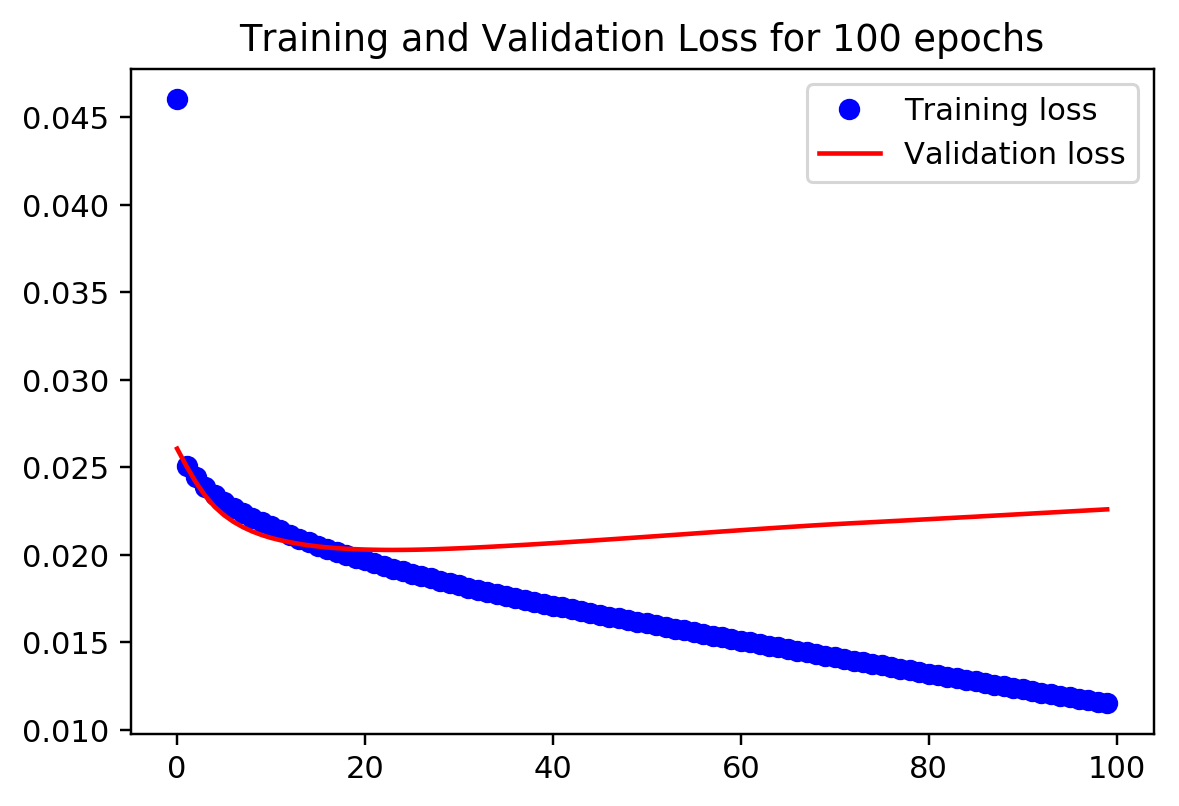

Done


In [10]:
# Example of how to run a hybrid fingerprint encoder

epochs = 100

x_train_dense = spectra
x_train_dense = np.log(x_train_dense+1)
x_train_fingerprints = fingerprints

# Add dimension for Conv1D layer
x_train_conv = np.expand_dims(x_train_dense, axis=2)

x_train_fingerprints = fingerprints

enc_hybrid = conv_autoencoder(x_train_conv, x_train_dense, x_train_fingerprints)

actual = x_train_fingerprints
predicted = enc_hybrid.predict([x_train_conv, x_train_dense]) # Note how a list of inputs is used, one dense, one convolutional
exp_stats, exp_perm_scores = compute_auc(actual, predicted)

In [46]:
# Basic comparisons of the two trained models
print(compute_auc(8, actual, predicted))
#evaluate(baseline_stats, baseline_perm_scores, exp_stats, exp_perm_scores)

[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]]
1368
[[2.39008412e-04 7.58076832e-02 1.80903524e-02 ... 5.40195080e-03
  9.98325169e-01 5.14779054e-03]
 [1.22536640e-05 1.81282719e-03 2.69094435e-05 ... 1.03753991e-01
  9.98204708e-01 5.48327633e-04]
 [4.94131062e-04 1.28615042e-03 6.98963031e-02 ... 2.26434693e-03
  9.66673195e-01 5.75433895e-02]
 ...
 [1.14586466e-04 1.31610886e-03 2.26295944e-02 ... 1.36320703e-02
  9.65439022e-01 1.14955224e-01]
 [2.65259645e-04 3.72154787e-02 1.90505758e-04 ... 6.21648319e-02
  9.99789298e-01 3.69156303e-04]
 [3.72417853e-05 2.26999726e-02 4.24878905e-03 ... 4.27584071e-03
  9.51603770e-01 3.75295967e-01]]
1368
4
Done
(array([(0, 10, 0.90351563,   0. ), (1, 52, 0.8174195 ,   0. ),
       (2,  9, 0.97760551,   0. ), (3,  9, 0.91559001,   0. ),
       (4,  0, 0.        , 100. ), (5,  1, 1.        ,   0.6),
       (6, 57, 0.89906866,   0. ), (7, 20, 0.88008475,   0. )],
      dty